In [5]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import tensorflow as tf

In [8]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [9]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [10]:
DATAROOT = "data"

In [11]:
multi_class_images = joblib.load(f"{DATAROOT}/multi_label_images.dict")
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")

In [12]:
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items() if k in multi_class_images}

In [13]:
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items() if k in multi_class_images}

In [14]:
assert len(raw_images) == len(original_images)
assert len(raw_images) == len(multi_class_images)

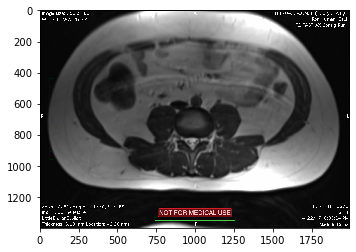

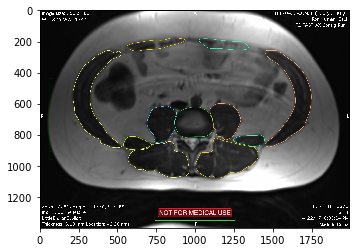

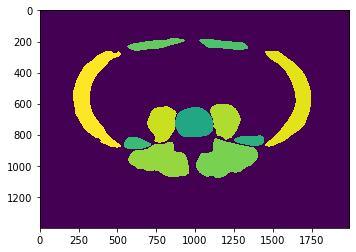

In [15]:
label = np.random.choice(list(multi_class_images.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])

In [16]:
TRAIN_SIZE = 400

In [17]:
from sklearn.model_selection import train_test_split
imgTrLabels, imgTsLabels, maskedTrLabels, maskedTsLabels = \
    train_test_split(list(raw_images.keys()), list(multi_class_images.keys()), random_state=17, test_size=.6)
imgTr = {k: raw_images[k] for k in imgTrLabels}
imgTs = {k: raw_images[k] for k in imgTsLabels}
maskedTr = {k: multi_class_images[k] for k in maskedTrLabels}
maskedTs = {k: multi_class_images[k] for k in maskedTsLabels}
assert len(imgTr) == len(maskedTr)
assert len(imgTs) == len(maskedTs)

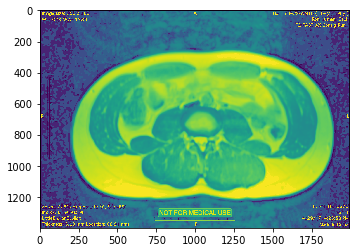

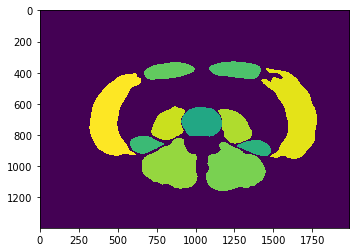

In [18]:
label = np.random.choice(list(maskedTr.keys()))
plt.imshow(cv2.equalizeHist(imgTr[label].mean(axis=2).astype('uint8')))
plt.show()
plt.imshow(maskedTr[label])

In [19]:
def clean_image(img, shape):
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in cleaned_hist_img.shape)
    cv2.GaussianBlur(cleaned_hist_img, gaussian_kernel_size, 1)
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = zoom(img, zoom_rate)
    return (out-out.mean())/out.std()

def clean_mask(img, shape):
    if len(img.shape) > 2:
        img = img.sum(axis=2).astype('uint8')
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = (zoom((img==c)*255, zoom_rate)>0)*c
        out.append(segment)
    return np.max(np.array(out), axis=0)

#def get_image_positional_values(img):
#    w, h, *_ = img.shape
#    x, y = np.meshgrid(np.arange(w)/w, np.arange(h)/h)
#    return np.vstack([x.reshape(-1), y.reshape(-1)]).T, img.reshape(-1)



mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F3B/4-COF3B-21:50RepBeh.jpg


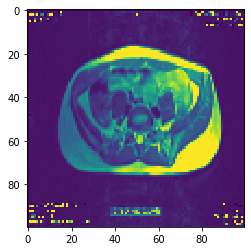

[  0 150 180 190 200 210 220 230 240 250]


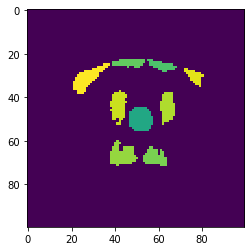

In [20]:
label = np.random.choice(list(maskedTr.keys()))
#label = "mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Female/Subject WF5B/1-WF5B-4:50RepBeh.jpg"
#label = 'mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F4/3-COF4-15:50Rep-Beh.jpg'
print(label)
plt.imshow(clean_image(imgTr[label], (100, 100)))
plt.show()
tmp = clean_mask(maskedTr[label], (100, 100))
plt.imshow(tmp)
print(np.unique(tmp))

In [15]:
imgTrB = bag.from_sequence(imgTr.values())
maskedTrB = bag.from_sequence(maskedTr.values())

In [16]:
cleaned_images_bag = imgTrB.map(clean_image, shape=300).persist()#[delayed(clean_image)(x, 200) for x in imgTr.values()]
cleaned_masks_bag = maskedTrB.map(clean_mask, shape=300).persist()#[delayed(clean_image)(x, 200) for x in imgTr.values()]

In [17]:
def sample(x, y, neighSize, step):
    m1 = neighSize//2
    m2 = neighSize-m1
    w, h, *_ = x.shape
    x_out = []
    y_out = []
    for i in range(m1, w-m2, step):
        for j in range(m1, h-m2, step):
            x_out.append(x[i-m1:i+m2, j-m1:j+m2])
            y_out.append(y[i, j])
    x = np.array(x_out)
    y = np.array(y_out)
    return x.reshape(*x.shape, 1), y.reshape(*y.shape, 1)

In [18]:
XY_bag = bag.map(sample, cleaned_images_bag, cleaned_masks_bag, 41, 3)

In [19]:
XY = XY_bag.compute()

In [ ]:
X = np.concatenate([x[0] for x in XY])
Y = np.concatenate([x[1] for x in XY])
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y).toarray()

In [73]:
X = (X-X.mean())/X.std()

In [28]:
from keras.preprocessing.image import ImageDataGenerator

In [74]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, 
	horizontal_flip=True, fill_mode="nearest")

In [81]:
# Keras simple deep model:
def build_v02(width, height, depth, init="he_normal"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
        
    # our first CONV layer will learn a total of 16 filters, each
    # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
    # the spatial dimensions of the volume
    #model.add(Conv2D(32, (10, 10), strides=(1, 1), padding="same",
    #    kernel_initializer=init,# kernel_regularizer=reg,
    #    input_shape=inputShape))

    # here we stack two CONV layers on top of each other where
    # each layerswill learn a total of 32 (3x3) filters
    model.add(Conv2D(32, (10, 10), padding="valid",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    #model.add(Conv2D(32, (5, 5), strides=(1, 1), padding="valid",
    #    kernel_initializer=init, #kernel_regularizer=reg)
    #                ))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.25))
    # stack two more CONV layers, keeping the size of each filter
    # as 3x3 but increasing to 64 total learned filters
    #model.add(Conv2D(64, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Dropout(0.25))
#
    ## increase the number of filters again, this time to 128
    #model.add(Conv2D(128, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(10, (3, 3), strides=(1, 1), padding="valid",
        kernel_initializer=init,  #kernel_regularizer=reg
                    )
             )
    model.add(Activation("relu"))
    #model.add(Conv2D(1, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, #kernel_regularizer=reg)
    #                ))
    model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(12))
    #model.add(Dense(1))
    model.add(Activation("sigmoid"))
    #model.add(BatchNormalization(axis=chanDim))
    return model

In [89]:
#model = build_v02(20, 20, depth=1)
model = load_model("data/model_04_muti_class_cnn_v03.modell")
opt = Adam(lr=1e-4)#, decay=1e-4 / epochs)
#model.compile(loss=losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
#model.save("data/model_04_muti_class_cnn_v03.model")

In [83]:
#BS = 64
#generator = aug.flow(X, Y, batch_size=BS)

In [85]:
model.fit(X, Y, epochs=1)
#model.fit_generator(generator,
#	steps_per_epoch=len(X) // BS, epochs=EPOCHS)

Epoch 1/1
2232448/2918154 [=====================>........] - ETA: 15:52 - loss: 0.3106 - acc: 0.9024

KeyboardInterrupt: 

In [ ]:
EPOCHS = 10
model.fit(X, Y, epochs=EPOCHS)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


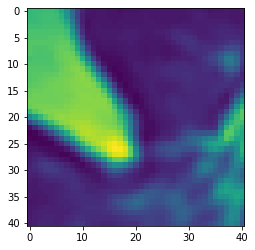

In [69]:
n = np.random.randint(len(X))
plt.imshow(X[n].reshape(41, 41))
print(Y[n])

In [72]:
X.mean()

0.1340883539676112

# Result: Failed

In [ ]:
cleaned_images_del = [delayed(clean_image)(x, 200) for x in imgTr.values()]
cleaned_masks = [delayed(clean_mask)(x, 200) for x in maskedTr.values()]

In [1]:
import tensorflow as tf

KeyError: "Couldn't find field google.protobuf.FieldDescriptorProto.proto3_optional"

In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9412608/9406464 [==============================] - 1s 0us/step


In [22]:
tf.tests

AttributeError: module 'tensorflow' has no attribute 'tests'